In [1]:
import json
import sys

import numba
import numpy as np
import pandas as pd
from scipy.stats import linregress

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Labels

We create a dataframe, `label_df` that only contains the label positions for each week.

In [12]:
with open(r'label_series.json', 'r') as fproc:
    label_series = json.load(fproc)

Unfortunately, the charts consist of a variable number of positions, therefore the missing values are padded with `np.nan`-s. Only the first hundred positions are kept.

In [13]:
label_series = {_k : _v.__add__([np.nan]*max((100 - len(_v)), 0))[:100] for _k, _v in label_series.items()}
label_df = pd.DataFrame(label_series)

#### Number of unique labels

Firstly, we calculate the number of labels for each week.

In [14]:
total_label_counts = pd.value_counts(label_df.values.ravel(), dropna = True)

#### Density

The label density, $\rho_{L}$ is defined as the number of different labels, $N_{L}$ divided by the number of positions, $N_{P}$:

$$
\rho_{L} = \frac{N_{L}}{N_{P}}
$$

Its value is in the $(0, 1]$ interval. The higher it is, the more labels are represented in the chart. It, however, does not reveal how equaly the singles distributed among labels. For example, let us assume there are 20 places and four labels, then $n_{L} = \frac{4}{20} = 0.2$ irrespective of whether one label has 17 positions and the rest one each, or each label has five positions. 

#### Entropy

The label entropy $H_{L}$ is the entropy of the label distribution. It reflects how uniformly the singles are distributed between labels. The entropy is normalised with its maximum possible value. It, therefore, ranges between 0, where one label owns the whole chart, and 1 where each single is published by a different label.

$$
H_{L} = \frac{\sum\limits_{l=1}^{N_{L}} - p_{l}\log(p_{l})}{\log(N_{L})}
$$

The _unnormalised_ Entropy is the counterpart of the label density in the sense that it does not carry information on the number of labels. For example, consider the cases two charts of length two and twenty where there are two labels both having equal number of hits (1-1 and 10-10), respectively. The entropy will be $H = -0.5 \cdot \log(0.5) -0.5 \cdot \log(0.5) = 1$. The normalising factor "penalises" the cases where the sample size is large, but the number of labels are low.

#### Diveristy

The diversity of the label distribution, $\lambda_{L}$ is defined as the probability that two randomly chosen singles belong to the same label. We invoke the Gini-Simpson diversity which is defined as

$$
    \lambda_{L} = \sum\limits_{l=1}^{N_{L}} p_{l}\, .
$$

The diversity both sensitive to the uniformity of the distribution and the sample size.

The number of positions and the three measures above are compared below.

In [15]:
label_number = label_df.count(axis = 0)
label_density = label_df.nunique(dropna = True) / label_df.count()
label_entropy = label_df.agg(calc_entropy, axis = 0)
label_diversity = label_df.agg(calc_gini_simpson, axis = 0)

The smoothed functions are also calculated.

In [16]:
window_size = 13
lde_sm = label_density.rolling(window_size).mean()[window_size:]
len_sm = label_entropy.rolling(window_size).mean()[window_size:]
ldi_sm = label_diversity.rolling(window_size).mean()[window_size:]

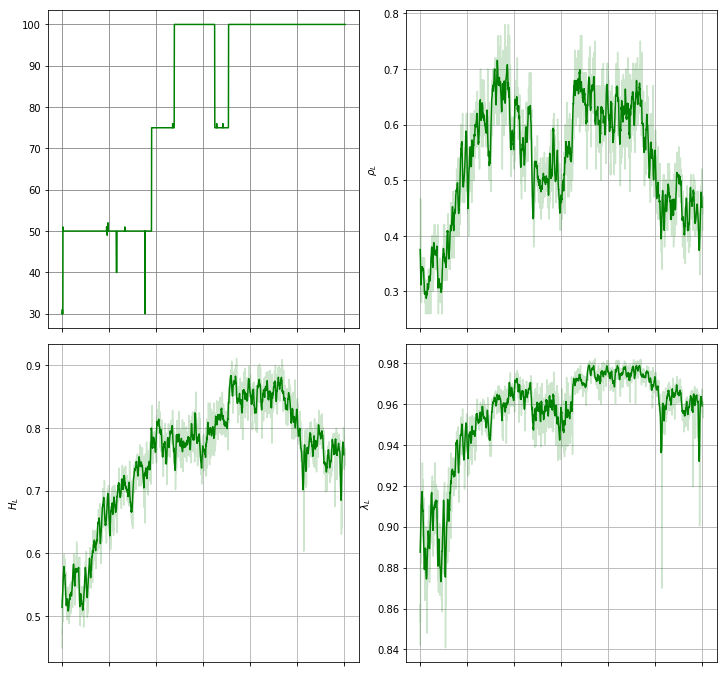

In [17]:
# TO HIDE

fig, axes = plt.subplots(2,2, sharex = True, gridspec_kw = {'hspace' : 0.05, 'wspace' : 0.15})
fig.set_size_inches(12,12)

data = ((label_density, lde_sm), (label_entropy, len_sm), (label_diversity, ldi_sm))
labels = (r'$\rho_{L}$', r'$H_{L}$', r'$\lambda_{L}$')

label_number.plot(ax = axes[0,0], color = 'green')
axes[0][0].xaxis.grid(color = 'grey')
axes[0][0].yaxis.grid(color = 'grey')

for axis, datum, label in zip(list(axes.flat)[1:], data, labels):
    datum[0].plot(ax = axis, alpha = 0.2, color = 'green')
    datum[1].plot(ax = axis, color = 'green', grid = True)
    axis.set_ylabel(label)

plt.show()

A number of observations can be made. 

* The number of positions does not influence the trend of the entropy.
* The time series can be divided to epochs. Each epoch is a temporal interval when both the density and entropy have consistent behaviour. These epochs in chronological order

1. Initial chaotic period
1. Both the density and entropy increases
1. The density decreases the entropy stalls
1. Both the density and entropy increases
1. Both the density and entropy increases
1. Both the density and entropy stalls

If the entropy is plotted against the density, an interesting layered pattern can be observed. Each elongated blob is suspected to correspond to an epoch. 

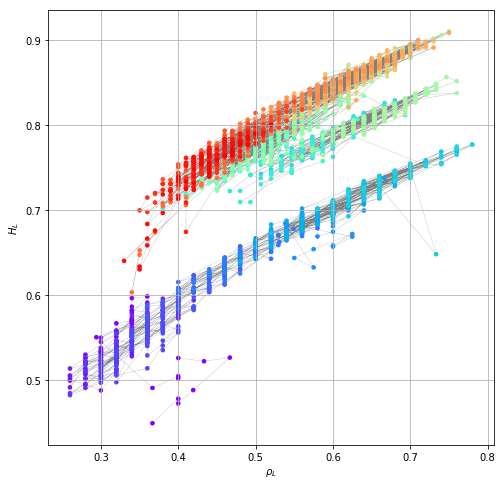

In [18]:
# TO HIDE

fig, ax = plt.subplots(1,1)
fig.set_size_inches(8,8)
ax.plot(label_density, label_entropy, c = 'grey', zorder = -1, lw = 0.2 )
ax.scatter(label_density, label_entropy, 
           c = plt.cm.rainbow(np.arange(label_density.size)/label_density.size), s = 13)
ax.grid(True)
ax.set_xlabel(r'$\rho_{L}$')
ax.set_ylabel(r'$H_{L}$')

plt.show()

The plot separated to decades reveal overlapping regions where the direction of the points are roughly the opposite.

In [19]:
# TO HIDE

dc = map(lambda x: x[0][:3] != x[1][:3], zip(label_density.index[:-1], label_density.index[1:]))
dd = label_density.index[1:][list(dc)]
dd = dd.insert(0, label_density.index[0]).append(pd.Index([label_density.index[-1]]))

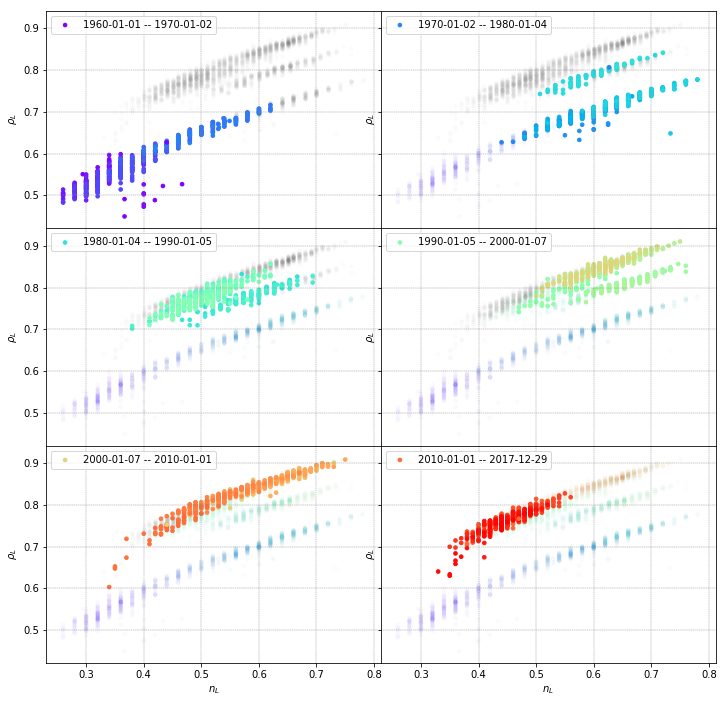

In [20]:
# TO HIDE

fig, axes = plt.subplots(3,2, sharex = True, sharey = True, 
                         gridspec_kw = {'hspace' : 0.0, 'wspace' : 0.0})
fig.set_size_inches(12,12)

for ax, (l_lim, u_lim) in zip(axes.flat, zip(dd[:-1], dd[1:])):
    
    label = str(l_lim) + ' -- ' + str(u_lim)
   
    l_crange = label_entropy.index.get_loc(l_lim)
    u_crange = label_entropy.index.get_loc(u_lim)

    #axis.plot(label_density[l_lim:u_lim], label_entropy[l_lim:u_lim], 
    #          color = 'black', alpha = 0.3)
    
    ax.scatter(label_density[u_lim:], label_entropy[u_lim:], s = 13, c = 'grey', alpha = 0.02)
    
    ax.scatter(label_density[:l_lim:], label_entropy[:l_lim], s = 13, alpha = 0.02,
                c = plt.cm.rainbow(np.arange(l_crange) / label_entropy.size))
    
    ax.scatter(label_density[l_lim:u_lim], label_entropy[l_lim:u_lim], s = 13, label = label,
                 c = plt.cm.rainbow(np.arange(l_crange,u_crange) / label_entropy.size))
    
    ax.legend(loc="upper left")
    ax.xaxis.grid(c = 'grey', linewidth = '0.4', linestyle = '--')
    ax.yaxis.grid(c = 'grey', linewidth = '0.4', linestyle = '--')

    ax.set_xlabel(r'$n_{L}$'); ax.set_ylabel(r'$\rho_{L}$'); 
plt.show()

The time can be used as a third axis to separate the points further. The figures below show progression the raw (left panel) and smoothed (right panel) time series.

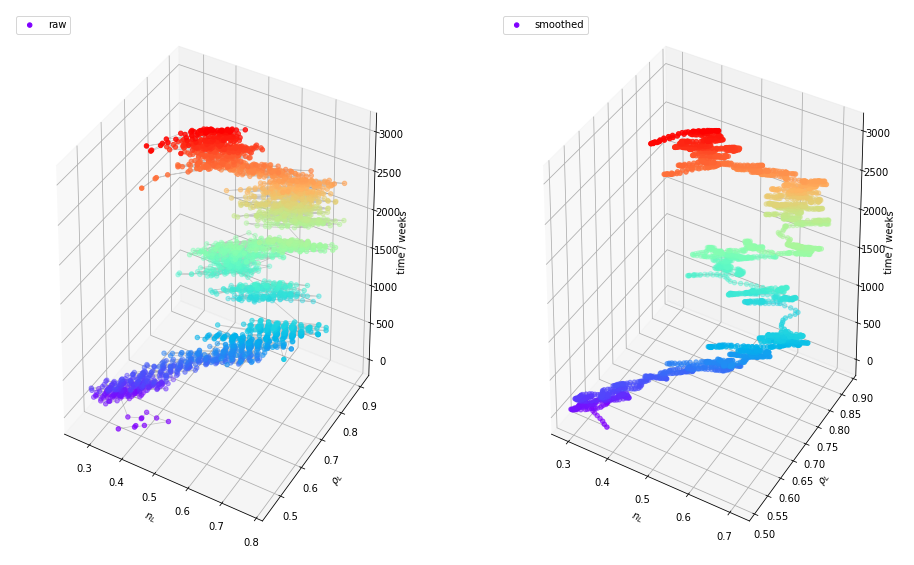

In [21]:
# TO HIDE

fig = plt.figure(figsize=plt.figaspect(0.5))
fig.set_size_inches(16,10)
ax = fig.add_subplot(1, 2, 1, projection='3d')

ax.scatter(label_density, label_entropy, np.arange(label_density.size),
          c = plt.cm.rainbow(np.arange(label_density.size)/label_density.size),
          label = 'raw')

ax.plot(label_density, label_entropy, np.arange(label_density.size), zorder = -1, 
        c = 'grey', alpha = 0.4, linewidth = 0.75)

ax.set_xlabel(r'$n_{L}$'); ax.set_ylabel(r'$\rho_{L}$'); ax.set_zlabel('time / weeks');
ax.legend(loc="upper left")

# smoothed
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.scatter(lde_sm, len_sm, np.arange(lde_sm.size),
           c = plt.cm.rainbow(np.arange(lde_sm.size)/lde_sm.size),
          label = 'smoothed')

ax.plot(lde_sm, len_sm, np.arange(lde_sm.size), zorder = -1, 
         c = 'grey', alpha = 0.4, linewidth = 0.75)

ax.set_xlabel(r'$n_{L}$'); ax.set_ylabel(r'$\rho_{L}$'); ax.set_zlabel('time / weeks');
ax.legend(loc="upper left")

plt.show()

## Finding epochs

We have established there are distinct sections in the time series. It is now time to quantitatively delimit them. 

### Clustering 

It might seem at first a good idea to cluster the data. There are two shortcomings of this procedure.

1. A bog standard clustering algorithm do not take into account the temporal order of the series. There are two remedies:

1.1 Cluster the data in the entropy--density space, then split the clusters based on temporal indices. The main drawback is the possibility of small sets of points of various temporal origin coalescing into a cluster which then cannot be separated.

1.1. Define a temporal distance and cluster the data in the entropy-density-time space.

Note, it is advisable to use _density based_ cluster algorithms, such as DBSCAN, as opposed to _distance based_ methods because of the elongated shape of the blobs.

### Segmenting

Are these epochs really clusters? The smoothed data suggest otherwise. The 'width' of the blobs arise from the fluctuations. These epochs are thus can be better described as noisy lines than clusters. Accordingly, we have to look metgods beyond clustering to identify the epochs.

We are going to use segmentation, that is the time series will be divided to non-overlapping subsequent regions. A region is a sequence of time series data where some property is consistent. The consistency of this property is measured by the loss function.

### Loss functions

In [82]:
n_points = 50
sigma_low = 1.0
sigma_high = 5.0

x = np.arange(n_points)
noise_low = sigma_low * np.random.randn(n_points)
noise_high = np.cumsum(sigma_high * 2* np.random.randn(n_points))

linear_ascend_noise_low = x + sigma_low * np.random.randn(n_points)
linear_descend_noise_low = - x + sigma_low * np.random.randn(n_points)

linear_ascend_noise_high = x + sigma_high * np.random.randn(n_points)
linear_descend_noise_high = - x + sigma_high * np.random.randn(n_points)

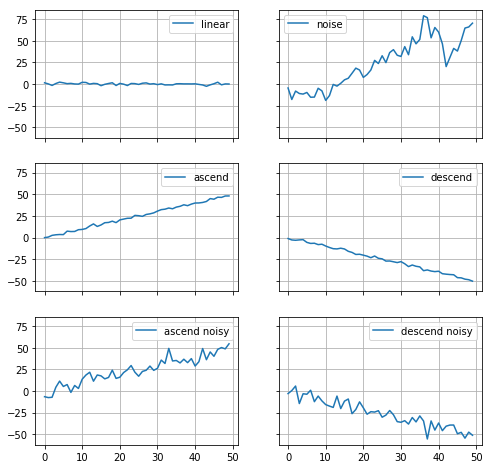

In [83]:
plot_data = noise_low, noise_high, linear_ascend, linear_descend, linear_ascend_noise_high, linear_descend_noise_high
plot_data_labels = 'linear', 'noise', 'ascend', 'descend', 'ascend noisy', 'descend noisy'

fig, axes = plt.subplots(3,2, sharex = True, sharey = True)
fig.set_size_inches(8,8)
for ax, data_, label_ in zip(axes.flat, plot_data, plot_data_labels):
    ax.plot(x, data_, label = label_)
    ax.grid(True)
    ax.legend()
plt.show()

In [75]:
def corr_var(x,y):

    npoints = x.shape[0]
    
    gen_idcs = (np.random.choice(npoints, size = npoints, replace = True) for i in range(100))
    gen_cc = (np.mean(x[idcs]) for idcs in gen_idcs)
    ccs = np.fromiter(gen_cc, dtype = np.float, count = 100)
    std = np.std(ccs)
    
    return std

In [76]:
for dt, lb in zip(plot_data, plot_data_labels):
    cc = corr_var(dt, np.arange(dt.shape[0]))
    print("{0} : {1}".format(lb, cc))

linear : 0.14271163912027873
noise : 1.1168497651525502
ascend : 1.8952591125818796
descend : 1.8703678421477865
ascend noisy : 1.8935398253044262
descend noisy : 2.3799221620009385


In [77]:
from itertools import combinations
merge_2_data = (np.ravel(np.array(m)) for m in combinations(plot_data, 2))
merge_2_labels = map( lambda x: "{0}-{1}".format(*x), combinations(plot_data_labels, 2))

for dt, lb in zip(merge_2_data, merge_2_labels):
    cc = corr_var(dt, np.arange(dt.shape[0]))
    print("{0} : {1}".format(lb, cc))

linear-noise : 1.2739136618016778
linear-ascend : 1.8989851355269132
linear-descend : 1.7151657780060667
linear-ascend noisy : 1.6748641856496067
linear-descend noisy : 1.719769643619314
noise-ascend : 2.6728738960653287
noise-descend : 1.1823728850891486
noise-ascend noisy : 2.830640240979699
noise-descend noisy : 1.3404429323307663
ascend-descend : 2.5497698177122703
ascend-ascend noisy : 1.6064894055484642
ascend-descend noisy : 2.6619477430968765
descend-ascend noisy : 2.978353614672459
descend-descend noisy : 1.2261928110938858
ascend noisy-descend noisy : 3.0522591770783567


#### Correlation based loss function

The loss function can base on the correlation function between the label density and entropy. If $p$ is a pattern comprising $N_{p}$ time series data, its associated cost, $L(p)$ is
$$
  L(p) = \big|\text{Corr}\big(n_{L,p}, \rho_{L,p}\big)\big| \cdot \frac{N_{p}}{\sum\limits_{p} N_{p}} \, .
$$

This measure penalises the lack of correlation, let it be positive or negative. The weight is the length of the pattern relative to the length of the entire time series. This function is implemented as `calculate_pattern_cc_cost`. Please note, the higher values of the loss function indicate better segmentation. This is because a genetic algorithm will be used, where higher values mean better solutions.

This function distinguishes between correlated and not-correlated regions of the time series. As such, it forces the solution to include segments where the overall correlation is the highest. Instead, we wish to distinguish between regions where the correlation is approximately constant. A better loss function would be the variance of the correlation. 

## Segmentation

We now embark on trying out our hashed segmentation optimisation. As a first step, the smoothed label density and label entropy stacked in a 2D array, `lde_len_sm` 

In [22]:
lde_len_sm = np.vstack([lde_sm, len_sm])

### Hashing accelerated segmentation

We are going to use hashing accelerated segmentation which consists of the follwing steps:

1. The time series is divided to $N_{b}$ subsequent blocks.
1. A hash table of the loss function values is created over all possible adjacent block merges, patterns, ($N_{b}^{2} \, / \,2$ hashed values).
1. The loss function is the sum of the losses associated with the patterns in a segmentation.
1. The best segmentation is found using population based incremental learning (PBIL) over the entire space ($2^{N_{b}-1}$ possible segmetnations).

The hashing is implemented in the [`HashBrown` class](https://bhornung.github.io/python/2018/09/15/hashing-time-series.html). The PBIL algorithm can be found [here](https://github.com/bhornung/PBIL).

In [23]:
sys.path.append(r'C:\Users\Balazs\source\repos\HashBrown')
sys.path.append(r'C:\Users\Balazs\source\repos\PBIL')

from HashBrown import calculate_block_indices, calculate_pattern_hash, calculate_loss_function, HashBrown
from PBIL import PBIL, tournament_selection

The hashed loss function values are stored in the `table` attribute of the `hs1` instance of the `HashBrown` class. The time series is divided to 100 blocks, each of having an approximate length of 30 weeks.

In [50]:
n_blocks = 100
block_indices = calculate_block_indices(lde_len_sm, n_blocks)

hs1 = HashBrown(lde_len_sm, n_blocks,  
                calculate_pattern_cc_cost, calculate_pattern_hash,
                func_args = [block_indices], hfunc_args = [n_blocks])

# create table
hs1.create_table()

The plot below shows the loss function for each (position, length) pattern). The blue regions correspond to segments where the correlation is low.

In [51]:
pattern_loss = [[pattern[0], pattern[1], hs1.table[hs1._hfunc(pattern, *hs1._hfunc_args)]]
                   for pattern in  hs1.create_pattern_generator()]

pattern_loss = np.nan_to_num(np.array(pattern_loss))

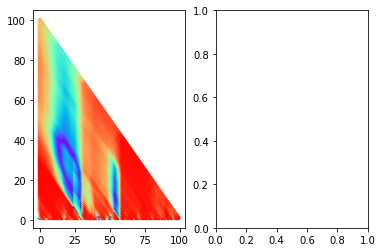

In [52]:
# TO HIDE

fig, axes = plt.subplots(1,2)

axes[0].scatter(pattern_loss[:,0], pattern_loss[:,1], 
                c = plt.cm.rainbow(pattern_loss[:,2]), s = 13)
plt.show()

The PBIL minimiser is initialised with the number inidivduals, `popsize`, the number of genes `(ngenes = n_blocks-1)`, the loss function `calculate_loss_function`, and the selection alagorithm which is tournament selection in our case. The number of iterations is also set.

In [54]:
popsize = 1000
ngenes = n_blocks - 1
tournament_size = 3
ntournaments = popsize

store = np.zeros(ngenes, dtype = np.int)

optimiser = PBIL(popsize, ngenes,
                calculate_loss_function,
                optim_kwargs = {'maxiter' : 2000},
                func_args = [store, hs1.table],
                selection_func = tournament_selection,
                selection_args = [tournament_size, ntournaments],
                verbosity = 1)

In [55]:
optimiser.fit()

===> Iteration: 1. Fitness of best gene: 61.3120079282914
===> Iteration: 2. Fitness of best gene: 61.3120079282914
===> Iteration: 3. Fitness of best gene: 61.3120079282914
===> Iteration: 4. Fitness of best gene: 61.3120079282914
===> Iteration: 5. Fitness of best gene: 64.16455249053108
===> Iteration: 6. Fitness of best gene: 64.16455249053108
===> Iteration: 7. Fitness of best gene: 64.16455249053108
===> Iteration: 8. Fitness of best gene: 64.16455249053108
===> Iteration: 9. Fitness of best gene: 64.16455249053108
===> Iteration: 10. Fitness of best gene: 64.16455249053108
===> Iteration: 11. Fitness of best gene: 64.16455249053108
===> Iteration: 12. Fitness of best gene: 64.16455249053108
===> Iteration: 13. Fitness of best gene: 64.16455249053108
===> Iteration: 14. Fitness of best gene: 64.16455249053108
===> Iteration: 15. Fitness of best gene: 64.16455249053108
===> Iteration: 16. Fitness of best gene: 64.16455249053108
===> Iteration: 17. Fitness of best gene: 64.16455249

In [56]:
segments = optimiser.best_individual

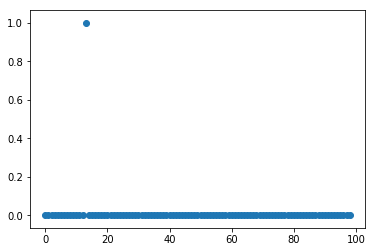

In [57]:
plt.scatter(np.arange(segments.size), segments)
plt.show()

### Miscellaneous functions

In [29]:
def calc_entropy(vals):
    """
    Calculates the entropy of a sample. The entropy is based on the frequency of distinct elements in the array.
    Parameters:
        vals (np.ndarray) : 1D numpy array
    Returns:
        entropy (float) : the normalised entropy 
    """
    idcs = ~pd.isnull(vals)
    values_, counts = np.unique(vals[idcs], return_counts = True)
    n_count = np.sum(counts)
        
    if n_count == 0:
        return 0.0

    prob = counts * 1.0 / n_count

    entropy = - np.dot(prob, np.log(prob))
    
    # normalise to maximum entropy
    max_entropy =  np.log(vals.size)
    
    entropy /= max_entropy
    
    return entropy

In [30]:
def calc_gini_simpson(vals):
    """
    Calculates the Gini--Simpson diversity of a sample.
    Parameters:
        vals (np.ndarray) : sample
    Returns : 
        gini_simpson (float) : the Gini--simson diversity
    """
    idcs = ~pd.isnull(vals)
    values_, counts = np.unique(vals[idcs], return_counts = True)
    n_count = np.sum(counts)
        
    if n_count == 0:
        return 0.0

    prob = counts * 1.0 / n_count

    gini_simpson = 1.0 - np.dot(prob, prob)
    
    return gini_simpson    

In [49]:
def calculate_pattern_cc_cost(pattern, f, block_indices):
    """
    Calculates the correlation coefficient in a section of a time series
    Parameters:
        pattern ((int, int)) : the position and length of section
        f (np.ndarray) : time series
        block_indices (npndarray of int) : the delimiting indices of the blocks
    Returns:
        cost (float) : the correlation coefficient weighted by the length of the section relative to
        the length of the entire time series
    """
    
    pos, length = pattern
    
    i_start = block_indices[pos, 0]
    i_end = block_indices[pos + length - 1, 1]

    cc = np.corrcoef(f[:,i_start:i_end], rowvar = True)[0,1]
    cost = np.abs(cc)
    
    pattern_length = i_end - i_start
    total_length = block_indices[-1,1] - block_indices[0,0]
    weigth = pattern_length  * 1.0 / total_length
    
    #cost *= weigth 
    
    return cost

In [47]:
def calculate_pattern_lr_cost(pattern, f, block_indices):
    """
    Calculates the goodness of fit (R^{2}) in a section of a time series
    Parameters:
        pattern ((int, int)) : the position and length of section
        f (np.ndarray) : time series
        block_indices (npndarray of int) : the delimiting indices of the blocks
    Returns:
        cost (float) : the R^{2} weighted by the length of the section relative to
        the length of the entire time series
    """
    
    pos, length = pattern
    
    i_start = block_indices[pos, 0]
    i_end = block_indices[pos + length - 1, 1]

    x = f[0,i_start:i_end]
    y = f[1,i_start:i_end]
    
    dx = np.subtract.outer(x, x)
    dy = np.subtract.outer(y, y)
    
    # remove zero denominator
    dx[np.arange(dx.shape[0]), np.arange(dx.shape[0])] = 1
    
    grad = np.abs(dy) / np.abs(dx)
    cost = np.stdev(grad)

    
    pattern_length = i_end - i_start
    total_length = block_indices[-1,1] - block_indices[0,0]
    weigth = pattern_length  * 1.0 / total_length
    
    #cost *= weigth
    
    return cost